# Stadtverkehrssimulation (Mesa)

Dieses Notebook implementiert eine Multi-Agenten-Simulation eines städtischen Verkehrssystems unter Verwendung von „mesa“.
Es vergleicht zwei Szenarien:
1. **Baseline**: Status-quo-Verhalten.
2. **IMBMS**: Ein intelligentes System, das zusätzliche Straßenbahnen einsetzt, wenn die Zufriedenheit der Fahrgäste sinkt.

In [1]:
import mesa
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


/opt/anaconda3/envs/mss-ngs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Definitionen der Akteure

Wir definieren zwei Arten von Akteuren:
- **PassengerAgent**: Pendler mit einem bevorzugten Verkehrsmittel (Bus/Straßenbahn). Sie haben einen Zufriedenheitswert, der während der Wartezeit sinkt. Lange Wartezeiten können einen Wechsel des Verkehrsmittels auslösen.
- **VehicleAgent**: Busse oder Straßenbahnen. Sie bewegen sich, nehmen Fahrgäste auf und stoßen CO2 aus. Busse können durch Baustellen verspätet sein.

Für die Emissionsrechnung verwenden wir folgende Parameter:
- Bus: $5$ CO2-Emissionen pro Tick
- Straßenbahn: $2$ CO2-Emissionen pro Tick

Stop and Go ist besonders ineffizient und diesen Zustand haben wir mit einem höheren CO2-Emissionsfaktor repräsentiert.

Für die Ticks haben wir uns diese folgende Frage ausgedacht:
Wie lange wartet ein Mensch an einer Bushaltestelle, bei der "in Kürze" steht, bevor er entnervt aufgibt und zur weiter entfernten Tramstation läuft?

Mit der **Annahme** das es in der Stadt etwa 10minuten sind.

$$30 Ticks = 10 Minuten = 600 Sekunden$$

$$1 Tick = \frac{600 Sekunden}{30} = 20 Sekunden$$

Unser Grid ist 50 Zellen breit und ein Fahrzeug bewegt sich $1$ Zelle pro Tick.

- **Simulation:** Eine Runde dauert $50$ Ticks (ohne Stau).
- **Realzeit:** $50 Ticks \times 20 Sekunden = 1000 Sekunden = 16 Minuten$
- **Realitäts-Check:** ist $16$ Minuten eine realistische Zeit für eine Buslinie, die einmal durch ein Stadtquartier (Hin- und Rückweg) fährt? **Ja**

## SusAF Dimensionen

- `self.satisfaction` im `PassengerAgent` haben wir für die Dimension SOZIAL
- `self.emissions` im `VehicleAgent` haben wir für die Dimension ÖKOLOGISCH
- `switch_to_tram` im `PassengerAgent` haben wir für die Dimension INDIVIDUEL
- `deploy_extra_tram` im `CityTransportModel` haben wir für die Dimension TECHNISCH -> `current_sat < 80`
- die Instaziierung von `VehicleAgent` haben wir für die Dimension WIRTSCHAFT -> `deploy_tram()`

In [2]:
# --- 1. Agenten ---

class PassengerAgent(mesa.Agent):
    def __init__(self, unique_id, model, transport_type_preference):
        super().__init__(model)
        self.unique_id = unique_id
        self.transport_type = transport_type_preference 
        self.waiting_time = 0
        self.satisfaction = 100
        self.arrived = False
        self.has_switched = False 

    def step(self):
        if not self.arrived:
            self.waiting_time += 1
            
            # Dimension: SOZIAL (Zufriedenheit sinkt)
            decay = 0.5 if self.transport_type == "Tram" else 0.8
            self.satisfaction -= decay
            if self.satisfaction < 0: self.satisfaction = 0

            # --- Verhalten 2. Ordnung: Mode-Switching ---
            # Wenn Agent auf Bus wartet UND länger als 30 Ticks wartet:
            if self.transport_type == "Bus" and self.waiting_time > 30:
                self.switch_to_tram()

    def switch_to_tram(self):
        """Der Passagier gibt auf und wechselt zum Tram."""
        self.transport_type = "Tram"
        self.has_switched = True
        self.satisfaction -= 10 # Wechselstress
        
        # Agent muss physisch auf die Tram-Spur (y=1) umziehen
        x, y = self.pos
        if y == 0: 
            self.model.grid.move_agent(self, (x, 1))

class VehicleAgent(mesa.Agent):
    def __init__(self, unique_id, model, v_type):
        super().__init__(model)
        self.unique_id = unique_id
        self.v_type = v_type 
        self.emissions = 0 # Dimension: ÖKOLOGISCH

    def step(self):
        x, y = self.pos
        moved = True
        
        # Baustelle bremst nur Busse
        if self.v_type == "Bus" and self.model.construction_active:
            if 10 <= x <= 20:
                if random.random() < 0.7: 
                    moved = False # Bus steht im Stau
                    # CO2: Stop & Go ist sehr ineffizient
                    self.emissions += 8
        
        # Bewegung
        if moved:
            new_x = (x + 1) % self.model.grid.width 
            self.model.grid.move_agent(self, (new_x, y))
            
            # CO2 Berechnung für Fahren
            if self.v_type == "Bus":
                self.emissions += 5  # Dieselbus Normalfahrt
            elif self.v_type == "Tram":
                self.emissions += 2  # Tram (Strom) - weniger als Bus, aber vorhanden

        # Passagiere einsammeln
        if moved:
            cell_mates = self.model.grid.get_cell_list_contents([(new_x, y)])
            for mate in cell_mates:
                if isinstance(mate, PassengerAgent) and not mate.arrived:
                    if mate.transport_type == self.v_type:
                        mate.arrived = True

## 2. Modelldefinition

Das `CityTransportModel` initialisiert das Raster und die Agenten. Es sammelt Daten bei jedem Schritt.
Wenn `scenario=‚imbms‘`, überwacht es die durchschnittliche Zufriedenheit und setzt eine zusätzliche Straßenbahn ein, wenn diese unter 80 fällt.

In [3]:
# --- 2. Modell mit IMBMS Logik ---

class CityTransportModel(mesa.Model):
    def __init__(self, num_passengers, scenario="baseline"):
        super().__init__()
        self.scenario = scenario # "baseline" oder "imbms"
        self.construction_active = True
        self.grid = mesa.space.MultiGrid(50, 2, torus=True)
        self.tram_deployed = False # Merker, ob System schon eingegriffen hat
        
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Avg_Satisfaction": compute_avg_satisfaction,
                "Total_Switchers": count_switchers,
                # Summe aller Emissionen aller Fahrzeuge
                "Total_CO2": lambda m: sum([a.emissions for a in m.agents if isinstance(a, VehicleAgent)])
            }
        )

        # Agenten ID Counter
        self.current_id = 0

        # 1. Fahrzeuge erstellen
        bus = VehicleAgent(self.next_id(), self, "Bus")
        self.grid.place_agent(bus, (0, 0))

        tram = VehicleAgent(self.next_id(), self, "Tram")
        self.grid.place_agent(tram, (0, 1))

        # 2. Passagiere erstellen
        for i in range(num_passengers):
            p_type = "Bus" if random.random() < 0.7 else "Tram"
            a = PassengerAgent(self.next_id(), self, p_type)
            x = random.randrange(self.grid.width)
            y = 0 if p_type == "Bus" else 1
            self.grid.place_agent(a, (x, y))

    def next_id(self):
        self.current_id += 1
        return self.current_id

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("step")
        
        # --- DAS INTELLIGENTE SYSTEM (IMBMS) ---
        if self.scenario == "imbms" and not self.tram_deployed:
            # Datenerfassung (Digital Twin)
            current_sat = compute_avg_satisfaction(self)
            
            # Entscheidungsschwelle: Wenn Zufriedenheit unter 80 fällt
            if current_sat < 80:
                self.deploy_extra_tram()

    def deploy_extra_tram(self):
        """Das System reagiert auf die Störung mit Taktverdichtung."""
        print(f"ALARM [Zeit {self.steps}]: Zufriedenheit kritisch! IMBMS sendet Verstärker-Tram.")
        # Neues Tram an den Start setzen
        new_tram = VehicleAgent(self.next_id(), self, "Tram")
        self.grid.place_agent(new_tram, (0, 1)) # Startet bei x=0 auf Tramspur
        self.tram_deployed = True

## 3. Hilfsfunktionen

Hilfsfunktionen für den DataCollector zur Berechnung von Metriken auf Modellebene.

In [4]:
# --- Hilfsfunktionen ---

def compute_avg_satisfaction(model):
    passengers = [a for a in model.agents if isinstance(a, PassengerAgent)]
    if not passengers: return 0
    return sum([a.satisfaction for a in passengers]) / len(passengers)

def count_switchers(model):
    return sum([1 for a in model.agents if isinstance(a, PassengerAgent) and a.has_switched])

## 4. Ausführung und Vergleich

Wir führen beide Szenarien (Baseline vs. IMBMS) für 150 Schritte aus und vergleichen die Ergebnisse mit Matplotlib.

--- Simulation 1: Status Quo (Kein System) ---

--- Simulation 2: IMBMS (Datengetriebene Lösung) ---
ALARM [Zeit 31]: Zufriedenheit kritisch! IMBMS sendet Verstärker-Tram.


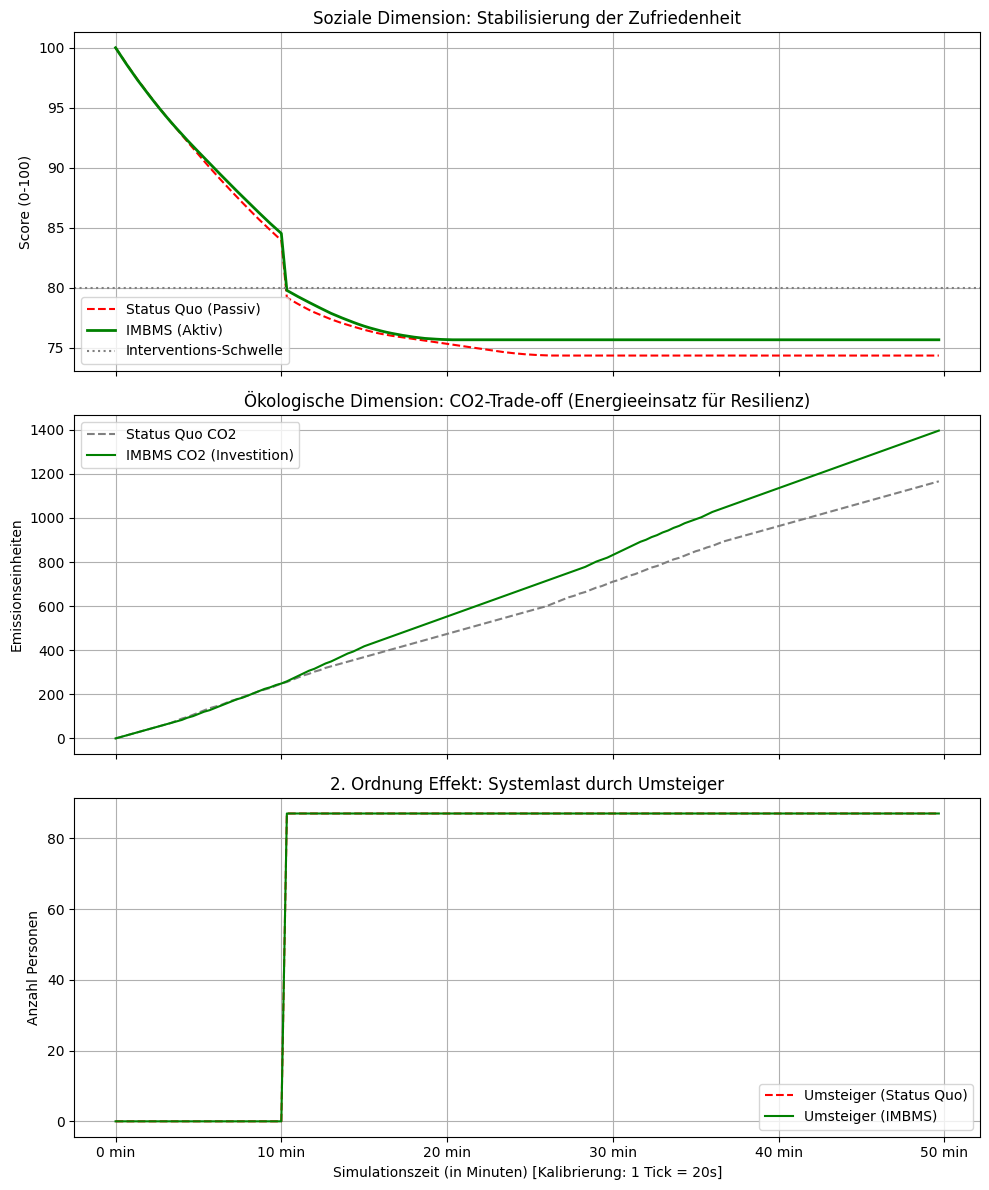

In [5]:
# --- 3. Ausführung & Vergleich ---

if __name__ == "__main__":
    steps = 150 # Entspricht 50 Minuten (bei 20sek/Tick)
    n_passengers = 200
    
    print("--- Simulation 1: Status Quo (Kein System) ---")
    model_base = CityTransportModel(n_passengers, scenario="baseline")
    for i in range(steps): model_base.step()
    res_base = model_base.datacollector.get_model_vars_dataframe()

    print("\n--- Simulation 2: IMBMS (Datengetriebene Lösung) ---")
    model_imbms = CityTransportModel(n_passengers, scenario="imbms")
    for i in range(steps): model_imbms.step()
    res_imbms = model_imbms.datacollector.get_model_vars_dataframe()

    # --- PLOTTING FÜR DEN LEISTUNGSNACHWEIS (NGS) ---
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # 1. Soziale Dimension: Zufriedenheit
    ax1.plot(res_base["Avg_Satisfaction"], label="Status Quo (Passiv)", color="red", linestyle="--")
    ax1.plot(res_imbms["Avg_Satisfaction"], label="IMBMS (Aktiv)", color="green", linewidth=2)
    ax1.axhline(y=80, color='gray', linestyle=':', label="Interventions-Schwelle")
    ax1.set_title("Soziale Dimension: Stabilisierung der Zufriedenheit")
    ax1.set_ylabel("Score (0-100)")
    ax1.legend(loc="lower left") # Legende verschoben damit sie nicht im Weg ist
    ax1.grid(True)

    # 2. Ökologische Dimension: CO2
    ax2.plot(res_base["Total_CO2"], label="Status Quo CO2", color="grey", linestyle="--")
    ax2.plot(res_imbms["Total_CO2"], label="IMBMS CO2 (Investition)", color="green")
    ax2.set_title("Ökologische Dimension: CO2-Trade-off (Energieeinsatz für Resilienz)")
    ax2.set_ylabel("Emissionseinheiten")
    ax2.legend()
    ax2.grid(True)

    # 3. Verhalten: Umsteiger
    ax3.plot(res_base["Total_Switchers"], label="Umsteiger (Status Quo)", color="red", linestyle="--")
    ax3.plot(res_imbms["Total_Switchers"], label="Umsteiger (IMBMS)", color="green")
    ax3.set_title("2. Ordnung Effekt: Systemlast durch Umsteiger")
    ax3.set_ylabel("Anzahl Personen")
    ax3.legend()
    ax3.grid(True)

    # --- X-ACHSE AUF MINUTEN UMSTELLEN ---
    # Kalibrierung: 1 Tick = 20 Sekunden -> 3 Ticks = 1 Minute
    # Wir wollen alle 10 Minuten eine Beschriftung anzeigen
    # 10 Minuten = 30 Ticks
    
    # Positionen für die Ticks (0, 30, 60, 90, 120, 150)
    major_ticks = list(range(0, steps + 1, 30)) 
    
    # Beschriftungen berechnen (Tick / 3 = Minute)
    tick_labels = [f"{int(t / 3)} min" for t in major_ticks]

    # Auf die unterste Achse (ax3) anwenden
    ax3.set_xticks(major_ticks)
    ax3.set_xticklabels(tick_labels)
    ax3.set_xlabel("Simulationszeit (in Minuten) [Kalibrierung: 1 Tick = 20s]")

    plt.tight_layout()
    plt.show()